In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


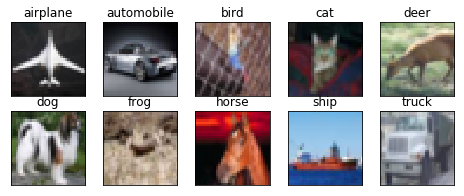

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Save test images to use later for GradCAM**

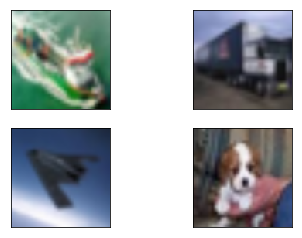

In [4]:
from google.colab.patches import cv2_imshow
from keras.datasets import cifar10
import cv2
import matplotlib.pyplot as plt
idx = [35,16,155,1600]
images = [test_features[i] for i,_ in enumerate(test_features) if i+1 in idx]
fig = plt.figure()
j=0
for i in images:
  j=j+1
  ax = fig.add_subplot(2, 2, j, xticks=[], yticks=[])
  img = cv2.resize(i, (128,128))
  plt.imshow(img)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Dense Layer Commented out

In [0]:
# # Define the model
# model = Sequential()
# model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
# model.add(Activation('relu'))
# model.add(Convolution2D(48, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Convolution2D(96, 3, 3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(Convolution2D(96, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Convolution2D(192, 3, 3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(Convolution2D(192, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# model.summary()

In [0]:
# # Defining checkpoints
# from keras.callbacks import ModelCheckpoint
# filepath="./Madhura_Assignment_6.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(zoom_range=0.0, 
#                              horizontal_flip=False)


# # train the model
# start = time.time()
# # Train the model
# model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
#                                  samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
#                                  validation_data = (test_features, test_labels), verbose=1,callbacks=callbacks_list)
# end = time.time()
# print ("Model took %0.2f seconds to train"%(end - start))
# # plot model history
# plot_model_history(model_info)
# # compute test accuracy
# print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## 6A is modified by applying GradCAM

In [9]:
# Define the model
model = Sequential()

# (32*32*3) -> (3*3*3)*32 -> (30*30*32)
# Receptive Field -> 3x3
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))

# (30*30*32) -> (3*3*32)*64 -> (28*28*64)
# Receptive Field -> 5x5
model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (28*28*64) -> MP -> (14*14*64)
# Receptive Field -> 10x10
model.add(MaxPooling2D(pool_size=(2, 2)))

# (14*14*64) -> (3*3*64)*64 -> (12*12*64)
# Receptive Field : 12x12
model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (12*12*128) -> (3*3*128)*128 -> (14*14*128)
# Receptive Field -> 14x14
model.add(Convolution2D(128, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (14*14*128) -> MP -> (7*7*128)
# Receptive Field -> 28x28
model.add(MaxPooling2D(pool_size=(2, 2)))

# (7*7*128) -> (1*1*128)*32 -> (7*7*32)
model.add(Convolution2D(32, 1, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# (7*7*32) -> (3*3*32)*32 -> (5*5*32)
# Receptive Field -> 30x30
model.add(Convolution2D(32, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (5*5*32) -> (3*3*32)*64 -> (3*3*64)
# Receptive Field -> 32x32
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu')) 
model.add(BatchNormalization())

#5*5*128
model.add(Convolution2D(10, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(10, 8))

model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipyke

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

# Defining checkpoints
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/Models/Assignment9A-01-0.600.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()
W0701 01:20:11.957916 139643481085824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_d

Epoch 1/100
195/195 [==============================] - 14s 74ms/step - loss: 1.4892 - acc: 0.4637 - val_loss: 1.4480 - val_acc: 0.5316

Epoch 00001: val_acc improved from -inf to 0.53160, saving model to /content/gdrive/My Drive/Models/Assignment9A-01-0.600.hdf5
Epoch 2/100
195/195 [==============================] - 9s 47ms/step - loss: 1.0547 - acc: 0.6234 - val_loss: 1.2179 - val_acc: 0.5631

Epoch 00002: val_acc improved from 0.53160 to 0.56310, saving model to /content/gdrive/My Drive/Models/Assignment9A-01-0.600.hdf5
Epoch 3/100
195/195 [==============================] - 9s 46ms/step - loss: 0.8630 - acc: 0.6950 - val_loss: 0.9305 - val_acc: 0.6848

Epoch 00003: val_acc improved from 0.56310 to 0.68480, saving model to /content/gdrive/My Drive/Models/Assignment9A-01-0.600.hdf5
Epoch 4/100
195/195 [==============================] - 9s 47ms/step - loss: 0.7494 - acc: 0.7365 - val_loss: 1.0356 - val_acc: 0.6592

Epoch 00004: val_acc did not improve from 0.68480
Epoch 5/100
195/195 [=

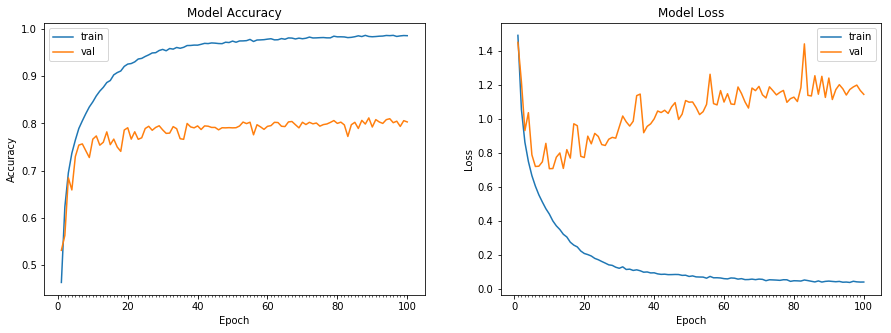

Accuracy on test data is: 80.29


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
from keras.models import load_model
filepath="/content/gdrive/My Drive/Models/Assignment9A-01-0.600.hdf5"
model = load_model(filepath)

-----Original-----  ----GRADCAM----


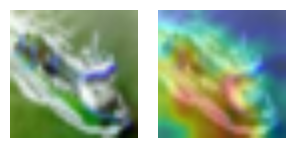

-----Original-----  ----GRADCAM----


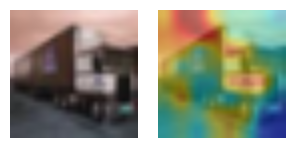

-----Original-----  ----GRADCAM----


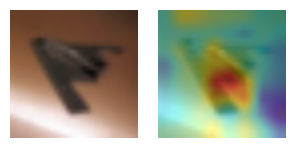

-----Original-----  ----GRADCAM----


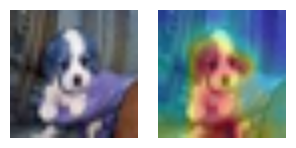

In [14]:
from keras.preprocessing import image
import keras.backend as K
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import preprocess_input
import numpy as np

white = [255,255,255] # For border

for img_path in images:
  x = image.img_to_array(img_path)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x) #Predicting
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_15") # Picking a layer

  # Find gradient of channel w.r.t layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i] #Pool the gradients
  
 # Average of weighted map, Relu and normalize values
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)    

  # Resize and blend the original and heatmap to superimpose the heatmap on to the image 
  img = img_path
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  img = cv2.resize(img, (128,128))
  superimposed_img = cv2.resize(superimposed_img, (128,128))
  img=cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=white) # Adding borders 
  superimposed_img=cv2.copyMakeBorder(superimposed_img,10,10,10,10,cv2.BORDER_CONSTANT,value=white)
  print('-----Original----- ' + ' ----GRADCAM----')
  numpy_horizontal = np.hstack((img, superimposed_img)) # Displaying in horizontal axis
  numpy_horizontal_concat = np.concatenate((img, superimposed_img), axis=1)
  cv2_imshow(numpy_horizontal_concat)
  cv2.waitKey(0)
 

##Using Cutout

In [15]:
# Define the model
model = Sequential()

# (32*32*3) -> (3*3*3)*32 -> (30*30*32)
# Receptive Field : 3x3
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))

# (30*30*32) -> (3*3*32)*64 -> (28*28*64)
# Receptive Field : 5x5
model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (28*28*64) -> MP -> (14*14*64)
# Receptive Field : 10x10
model.add(MaxPooling2D(pool_size=(2, 2)))

# (14*14*64) -> (3*3*64)*64 -> (12*12*64)
# Receptive Field : 12x12
model.add(Convolution2D(64, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (12*12*128) -> (3*3*128)*128 -> (14*14*128)
# Receptive Field : 14x14
model.add(Convolution2D(128, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (14*14*128) -> MP -> (7*7*128)
# Receptive Field : 28x28
model.add(MaxPooling2D(pool_size=(2, 2)))

# (7*7*128) -> (1*1*128)*32 -> (7*7*32)
model.add(Convolution2D(32, 1, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# (7*7*32) -> (3*3*32)*32 -> (5*5*32)
# Receptive Field : 30x30
model.add(Convolution2D(32, 3, 3, border_mode='same',activation='relu')) 
model.add(BatchNormalization())

# (5*5*32) -> (3*3*32)*64 -> (3*3*64)
# Receptive Field : 32x32
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu')) 
model.add(BatchNormalization())

#5*5*128
model.add(Convolution2D(10, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Convolution2D(10, 8))

model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipyke

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        36928     
__________

In [0]:
# Defining checkpoints
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/Models/Assignment9A_Coutout-{epoch:02d}-{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

--2019-07-01 01:39:09--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py’

random_eraser.py    100%[===================>]     888  --.-KB/s    in 0s      

2019-07-01 01:39:09 (202 MB/s) - ‘random_eraser.py’ saved [888/888]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=100)`
  


Epoch 1/100
195/195 [==============================] - 12s 60ms/step - loss: 1.5846 - acc: 0.4248 - val_loss: 1.4135 - val_acc: 0.4944

Epoch 00001: val_acc improved from -inf to 0.49440, saving model to /content/gdrive/My Drive/Models/Assignment9A_Coutout-01-0.494.hdf5
Epoch 2/100
195/195 [==============================] - 9s 47ms/step - loss: 1.2000 - acc: 0.5651 - val_loss: 1.1986 - val_acc: 0.5839

Epoch 00002: val_acc improved from 0.49440 to 0.58390, saving model to /content/gdrive/My Drive/Models/Assignment9A_Coutout-02-0.584.hdf5
Epoch 3/100
195/195 [==============================] - 9s 47ms/step - loss: 1.0030 - acc: 0.6409 - val_loss: 1.1544 - val_acc: 0.6164

Epoch 00003: val_acc improved from 0.58390 to 0.61640, saving model to /content/gdrive/My Drive/Models/Assignment9A_Coutout-03-0.616.hdf5
Epoch 4/100
195/195 [==============================] - 9s 47ms/step - loss: 0.8911 - acc: 0.6835 - val_loss: 1.0119 - val_acc: 0.6421

Epoch 00004: val_acc improved from 0.61640 to 0.

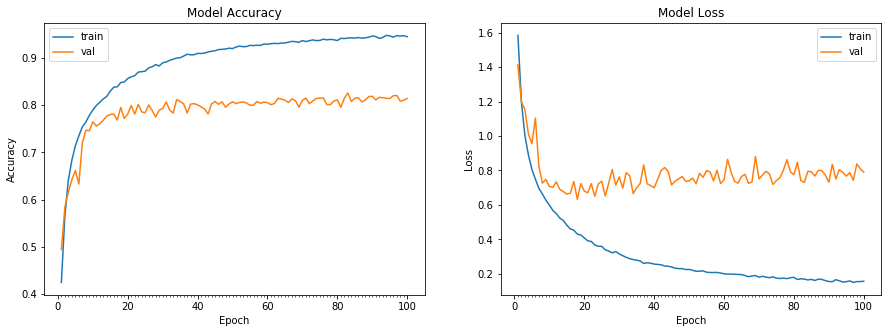

Accuracy on test data is: 81.45


In [18]:
!wget https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
from random_eraser import get_random_eraser
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = callbacks_list
                                )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

-----Original-----  ----GRADCAM----


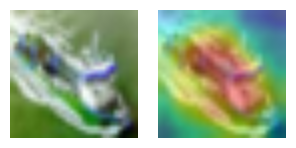

-----Original-----  ----GRADCAM----


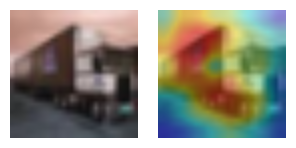

-----Original-----  ----GRADCAM----


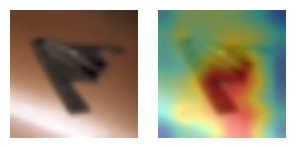

-----Original-----  ----GRADCAM----


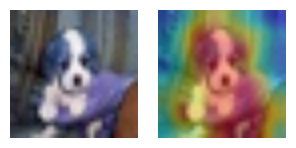

In [19]:
from keras.preprocessing import image
import keras.backend as K
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import preprocess_input
import numpy as np

white = [255,255,255] # For border

for img_path in images:
  x = image.img_to_array(img_path)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x) #Predicting
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_25") # Picking a layer

  # Find gradient of channel w.r.t layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i] #Pool the gradients
  
 # Average of weighted map, Relu and normalize values
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)    

  # Resize and blend the original and heatmap to superimpose the heatmap on to the image 
  img = img_path
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  img = cv2.resize(img, (128,128))
  superimposed_img = cv2.resize(superimposed_img, (128,128))
  img=cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=white) # Adding borders 
  superimposed_img=cv2.copyMakeBorder(superimposed_img,10,10,10,10,cv2.BORDER_CONSTANT,value=white)
  print('-----Original----- ' + ' ----GRADCAM----')
  numpy_horizontal = np.hstack((img, superimposed_img)) # Displaying in horizontal axis
  numpy_horizontal_concat = np.concatenate((img, superimposed_img), axis=1)
  cv2_imshow(numpy_horizontal_concat)
  cv2.waitKey(0)
 